In [10]:
import numpy as np

def set_state(Q, map, state):
    map[1] = ["", "", ""]
    map[1][state] = "X"
    print(map)
    print(Q)

Q = np.zeros([3, 3])
map = np.array([["_", "_", "X"], ["", "", ""]])

max_steps = 10
alpha = 0.1  # коэф. обучения
gamma = 0.9  # коэф. дисконтирования
epsilon = 0.1  # параметр исследования vs. эксплуатации

actions = {"left": -1, "right": 1}

for episode in range(max_steps):  # колво эпизодов обучения
    state = 0  # стартовое состояние
    if episode == 0:
        set_state(Q, map, state)

    while state != 2:  # пока не достигнута цель
        # выбор действия
        if np.random.rand() < epsilon:
            direction = actions[list(actions.keys())[np.random.randint(0, 1)]]
            action = np.clip(state + direction, 0, 2)  # случайное действие
        else:
            action = np.argmax(Q[state])

        # переход в новое состояние и получение награды
        new_state = action
        reward = (
            -1 if new_state != 2 else 0
        )  # награда -1 за каждый шаг, 0 за достижение цели

        # обновление Q-значения
        Q[state, action] = (1 - alpha) * Q[state, action] + alpha * (
            reward + gamma * np.max(Q[new_state])
        )

        state = new_state
        set_state(Q, map, state)
        
    print(f"Episode {episode + 1} is done")

[['_' '_' 'X']
 ['X' '' '']]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[['_' '_' 'X']
 ['X' '' '']]
[[-0.1  0.   0. ]
 [ 0.   0.   0. ]
 [ 0.   0.   0. ]]
[['_' '_' 'X']
 ['' 'X' '']]
[[-0.1 -0.1  0. ]
 [ 0.   0.   0. ]
 [ 0.   0.   0. ]]
[['_' '_' 'X']
 ['X' '' '']]
[[-0.1 -0.1  0. ]
 [-0.1  0.   0. ]
 [ 0.   0.   0. ]]
[['_' '_' 'X']
 ['' '' 'X']]
[[-0.1 -0.1  0. ]
 [-0.1  0.   0. ]
 [ 0.   0.   0. ]]
Episode 1 is done
[['_' '_' 'X']
 ['' '' 'X']]
[[-0.1 -0.1  0. ]
 [-0.1  0.   0. ]
 [ 0.   0.   0. ]]
Episode 2 is done
[['_' '_' 'X']
 ['' '' 'X']]
[[-0.1 -0.1  0. ]
 [-0.1  0.   0. ]
 [ 0.   0.   0. ]]
Episode 3 is done
[['_' '_' 'X']
 ['' '' 'X']]
[[-0.1 -0.1  0. ]
 [-0.1  0.   0. ]
 [ 0.   0.   0. ]]
Episode 4 is done
[['_' '_' 'X']
 ['X' '' '']]
[[-0.19 -0.1   0.  ]
 [-0.1   0.    0.  ]
 [ 0.    0.    0.  ]]
[['_' '_' 'X']
 ['' '' 'X']]
[[-0.19 -0.1   0.  ]
 [-0.1   0.    0.  ]
 [ 0.    0.    0.  ]]
Episode 5 is done
[['_' '_' 'X']
 ['' '' 'X']]
[[-0.19 -0.1   0.  ]
 [-0.1   0.    0.  ]

In [7]:
import gymnasium as gym


class MyAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        epsilon: float,
        discount_factor,
    ):
        self.env = env
        self.q_values = np.zeros([3, 3])  # type: ignore

        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = epsilon

        self.training_error = []

    def get_action(self, state: int) -> int:
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return int(np.argmax(self.q_values[state]))

    def update(
        self,
        state: int,
        action: int,
        reward: float,
        terminated: bool,
        new_state,
    ):
        future_q_value = (not terminated) * np.max(self.q_values[new_state])
        current_q_value = self.q_values[state][action]
        temporal_difference = (
            reward + self.discount_factor * future_q_value - current_q_value
        )

        self.q_values[state][action] = (
            1 - self.learning_rate
        ) * current_q_value + self.learning_rate * (
            reward + self.discount_factor * future_q_value
        )

        self.training_error.append(temporal_difference)

    def render(self):
        return "\n".join(
            [", ".join([str(item) for item in row]) for row in self.q_values]
        )


class MyEnv(gym.Env):
    metadata = {"render_modes": ["ansi", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None):
        self.size = 3

        self.render_mode = render_mode

        self._agent_location = 0
        self._target_location = 2

        self.observation_space = gym.spaces.Dict(
            {
                "agent": gym.spaces.Discrete(1),
                "target": gym.spaces.Discrete(1),
            }
        )

        self.action_space = gym.spaces.Discrete(2)
        self._action_to_direction = {
            0: -1,  # left
            1: 1,  # right
        }

    def _get_obs(self):
        return {
            "agent": self._agent_location,
            "target": self._target_location,
        }

    def _get_info(self):
        return {"distance": abs(self._agent_location - self._target_location)}

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._agent_location = 0
        self._target_location = 2
        observation = self._get_obs()
        info = self._get_info()

        return observation, info

    def step(self, action):
        direction = 0 if action == 2 else self._action_to_direction[action]
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )
        if (action == 2):
            self._agent_location = self._target_location

        terminated = self._agent_location == self._target_location
        truncated = False
        reward = -1 if not terminated else 0
        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, truncated, info

    def render(self):
        map = ['_', '_', '_']
        map[self._agent_location] = "A"
        map[self._target_location] = "X"
        return "   ".join(map)


env_id = "gymnasium_env/MyEnv-v1"
gym.register(
    id=env_id,
    entry_point=MyEnv,  # type: ignore
)

/Users/user/Projects/python/mai/.venv/lib/python3.12/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment gymnasium_env/MyEnv-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [8]:
from gymnasium.wrappers import RecordEpisodeStatistics

myenv = gym.make(env_id, render_mode="ansi", max_episode_steps=max_steps)
myenv = RecordEpisodeStatistics(myenv, buffer_length=max_steps)

agent = MyAgent(
    env=myenv,
    learning_rate=alpha,
    epsilon=epsilon,
    discount_factor=gamma,
)

action_num = 0
for episode in range(max_steps):
    obs, info = myenv.reset()
    done = False

    if episode == 0:
        print(myenv.render())
        print(agent.render())

    print(f"\n===> Start episode {episode + 1}")

    while not done:
        print(f"\nStart action {action_num + 1}")
        action_num = action_num + 1

        action = agent.get_action(obs["agent"])
        next_obs, reward, terminated, truncated, info = myenv.step(action)

        # update the agent
        agent.update(obs["agent"], action, float(reward), terminated, next_obs["agent"])

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs
        print(myenv.render())
        print(agent.render())

    print(f"\n===> Episode {episode + 1} is done")

myenv.close()

A   _   X
0.0, 0.0, 0.0
0.0, 0.0, 0.0
0.0, 0.0, 0.0

===> Start episode 1

Start action 1
A   _   X
-0.1, 0.0, 0.0
0.0, 0.0, 0.0
0.0, 0.0, 0.0

Start action 2
_   A   X
-0.1, -0.1, 0.0
0.0, 0.0, 0.0
0.0, 0.0, 0.0

Start action 3
A   _   X
-0.1, -0.1, 0.0
-0.1, 0.0, 0.0
0.0, 0.0, 0.0

Start action 4
_   _   X
-0.1, -0.1, 0.0
-0.1, 0.0, 0.0
0.0, 0.0, 0.0

===> Episode 1 is done

===> Start episode 2

Start action 5
_   _   X
-0.1, -0.1, 0.0
-0.1, 0.0, 0.0
0.0, 0.0, 0.0

===> Episode 2 is done

===> Start episode 3

Start action 6
_   _   X
-0.1, -0.1, 0.0
-0.1, 0.0, 0.0
0.0, 0.0, 0.0

===> Episode 3 is done

===> Start episode 4

Start action 7
_   _   X
-0.1, -0.1, 0.0
-0.1, 0.0, 0.0
0.0, 0.0, 0.0

===> Episode 4 is done

===> Start episode 5

Start action 8
_   _   X
-0.1, -0.1, 0.0
-0.1, 0.0, 0.0
0.0, 0.0, 0.0

===> Episode 5 is done

===> Start episode 6

Start action 9
A   _   X
-0.19, -0.1, 0.0
-0.1, 0.0, 0.0
0.0, 0.0, 0.0

Start action 10
_   _   X
-0.19, -0.1, 0.0
-0.1, 0.0, 0.0


/Users/user/Projects/python/mai/.venv/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/Users/user/Projects/python/mai/.venv/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


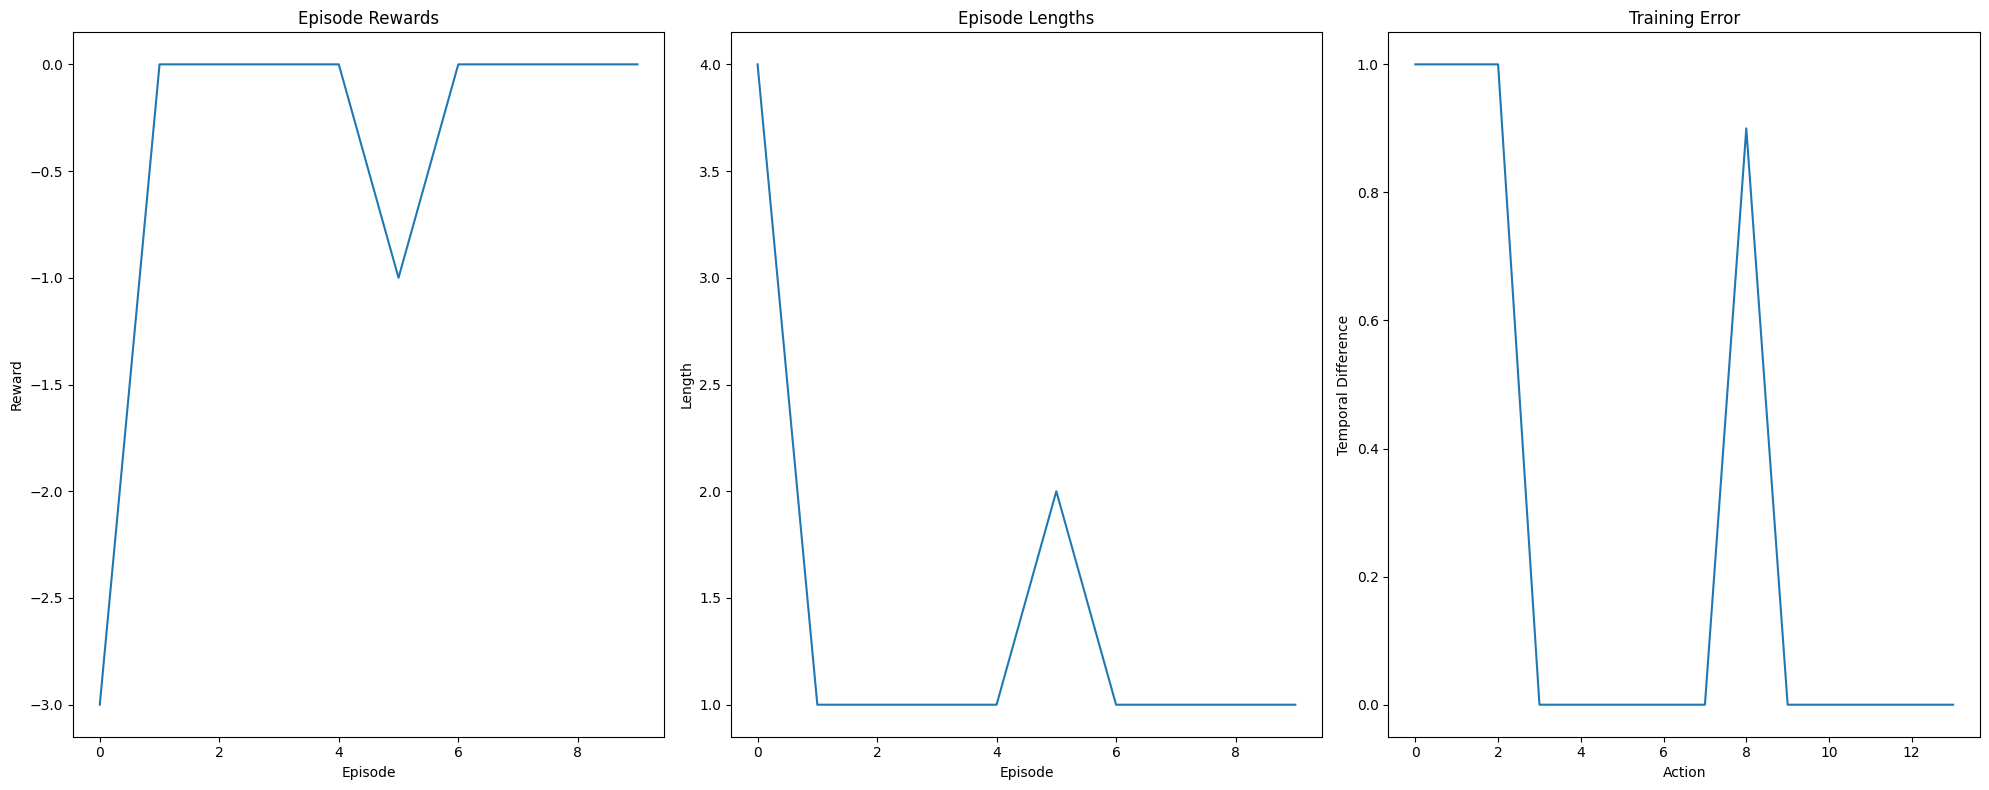

In [9]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(20, 8))

axs[0].plot(np.convolve(myenv.return_queue, np.ones(1)))  # type: ignore
axs[0].set_title("Episode Rewards")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Reward")

axs[1].plot(np.convolve(myenv.length_queue, np.ones(1)))  # type: ignore
axs[1].set_title("Episode Lengths")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Length")

axs[2].plot(np.convolve(agent.training_error, np.ones(1) * -1))
axs[2].set_title("Training Error")
axs[2].set_xlabel("Action")
axs[2].set_ylabel("Temporal Difference")

plt.tight_layout()
plt.show()